In [1]:
import treecorr as tc
import healpy as hp
import numpy as np
import matplotlib.pyplot as plt
from astropy.cosmology import Planck18 as cosmos
from astropy import units as u
h = cosmos.H0.value

In [2]:
quasar = np.load('../catalogue/quasar_lss.npy')
random = np.load('../catalogue/random_quasar_lss.npy')

In [3]:
Nbins = 15
rp_bin = np.geomspace(3, 100, Nbins+1)

z = 1.69
h = cosmos.H0.to(u.km/u.s/u.Mpc).value / 100
d_A = cosmos.angular_diameter_distance(z).to(u.Mpc).value
chi_l = d_A*(1+z)

theta_bins = rp_bin/h/(1+z)/d_A
theta_bins_deg = np.rad2deg(theta_bins)

In [8]:
import NN_correlation as NN

In [12]:
import importlib
importlib.reload(NN)

<module 'NN_correlation' from '/uufs/astro.utah.edu/common/home/u6060319/quasar-CMBlening/jupyter/NN_correlation.py'>

In [13]:
D = NN.w_theta_counter(True, quasar['ra'], quasar['dec'], quasar['w'], theta_bins)

100%|██████████| 26734/26734 [00:46<00:00, 570.02it/s]


In [14]:
R = NN.w_theta_counter(True, random['ra'], random['dec'], random['w'], theta_bins)
DR = NN.w_theta_counter(False, quasar['ra'], quasar['dec'], quasar['w'], theta_bins, random['ra'], random['dec'], random['w'])

  0%|          | 650/534688 [00:36<7:21:15, 20.17it/s]

KeyboardInterrupt: 

  0%|          | 1180/534688 [01:03<7:24:43, 19.99it/s]

In [8]:
D = tc.Catalog(ra=quasar['ra'], dec=quasar['dec'], ra_units='deg', dec_units='deg', w=quasar['w'], npatch=100)
R = tc.Catalog(ra=random['ra'], dec=random['dec'], ra_units='deg', dec_units='deg', w=random['w'])

In [9]:
config = {'metric': 'Arc', 'max_sep': theta_bins[-1], 'min_sep': theta_bins[0], 'nbins':Nbins, 'sep_units': 'rad', 'var_method':'jackknife'}
DD = tc.NNCorrelation(config=config)
DR = tc.NNCorrelation(config=config)
RR = tc.NNCorrelation(config=config)

DD.process(D)
DR.process(D, R)
RR.process(R)

In [10]:
xi, var_xi = DD.calculateXi(dr=DR, rr=RR)

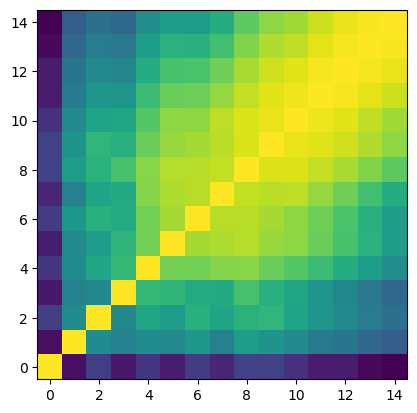

In [9]:
cov = DD.cov.copy()
diag = [cov[i,i] for i in range(cov.shape[0])]
for i in range(cov.shape[0]):
    for j in range(cov.shape[1]):
        cov[i,j] /= np.sqrt(diag[i]*diag[j])
plt.imshow(cov, origin='lower')

Text(0, 0.5, '$w(\\theta)$')

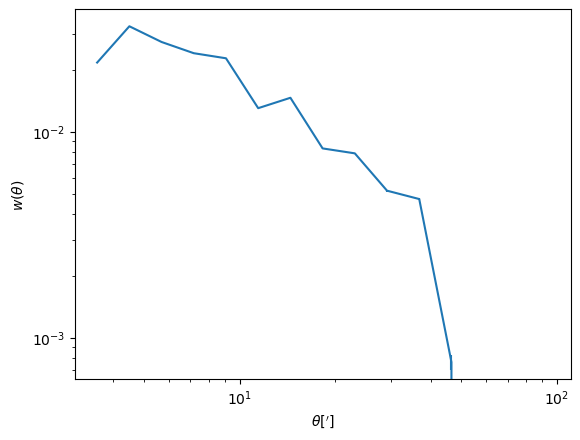

In [11]:
plt.errorbar((np.exp(DD.logr)*u.rad).to(u.arcmin), xi, var_xi)
plt.loglog()
plt.xlabel('$\\theta[\']$')
plt.ylabel('$w(\\theta)$')
# plt.savefig('./fig/w_theta_old')
plt.show()

<ErrorbarContainer object of 3 artists>

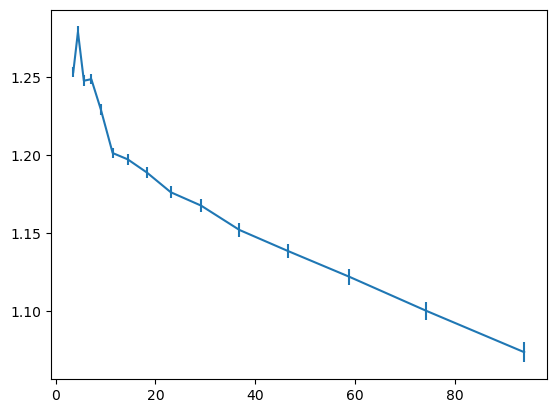

In [50]:
xi, var_xi = DD.calculateXi(dr=DR, rr=RR)
plt.errorbar((np.exp(DD.logr)*u.rad).to(u.arcmin), xi, var_xi)

In [15]:
dd = np.load('../calculation_data/output_dd.npy')
dr = np.load('../calculation_data/output_dr.npy')
rr = np.load('../calculation_data/output_rr.npy')

`dd.sum(axis=0)/2 == DD.npairs`

`dr.sum(axis=0) ~ DR.npairs * 1.43`

In [23]:
Nd = dd.shape[0]
Nr = rr.shape[0]
dd_res = dd.sum(axis=0)/2/(Nd*(Nd-1)/2)     # in my code, I calculated the same stuff twice, so it should be divided by two.
dr_res = dr.sum(axis=0)/(Nd*Nr)
rr_res = rr.sum(axis=0)/2/(Nr*(Nr-1)/2)

In [24]:
result = (dd_res - 2*dr_res + rr_res)/rr_res

In [25]:
theta = np.sqrt(theta_bins[1:]*theta_bins[:-1])

[]

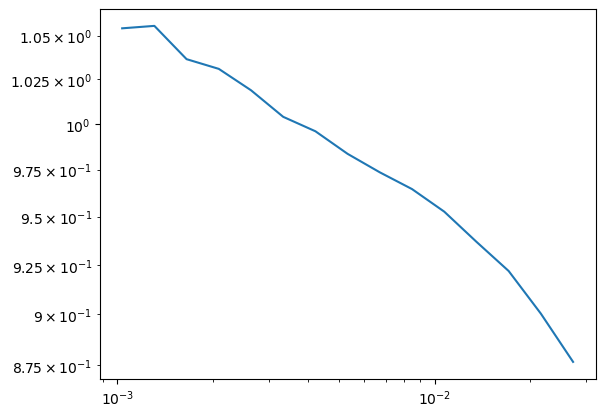

In [26]:
plt.plot(theta, result)
plt.loglog()